In [3]:
import os
from contextlib import suppress
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams.update({"figure.dpi": 120})

# Target columns used throughout the script
TARGET_COLS: List[str] = ["IC50, mM", "CC50, mM", "SI"]

In [5]:
def load_data(file_path: str) -> pd.DataFrame:
    df = pd.read_excel(file_path, engine="openpyxl")
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])
    numeric_cols = df.select_dtypes(include=["float", "int"]).columns
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
    return df


In [6]:
def basic_summary(df: pd.DataFrame) -> None:
    print("Data shape:", df.shape)
    print("\nColumn types:\n", df.dtypes)

    missing = df.isna().sum()
    nz_missing = missing[missing > 0]
    print("\nMissing values per column (non-zero entries shown):")
    print(nz_missing if not nz_missing.empty else "No missing values detected.")

    print("\nSummary statistics for target variables:")
    print(df[TARGET_COLS].describe())

In [7]:
def plot_target_distributions(df: pd.DataFrame, outdir: Path) -> None:
    titles = {
        "IC50, mM": "Distribution of IC50 (mM)",
        "CC50, mM": "Distribution of CC50 (mM)",
        "SI": "Distribution of Selectivity Index (SI)",
    }
    for col, title in titles.items():
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col].dropna(), kde=True, bins=30)
        plt.title(title)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.savefig(outdir / f"hist_{col.replace(', ', '_').replace(' ', '_')}.png")
        plt.close()

In [8]:
def _numeric_feature_columns(df: pd.DataFrame, target: str) -> List[str]:
    numeric_df = df.select_dtypes(include=[np.number])
    feature_cols = [
        c
        for c in numeric_df.columns
        if c not in TARGET_COLS and c != target and numeric_df[c].dropna().nunique() > 1
    ]
    return feature_cols

In [9]:
def compute_correlations(df: pd.DataFrame, target: str, k: int = 15) -> pd.Series:
    feature_cols = _numeric_feature_columns(df, target)
    subset = df[[target] + feature_cols].dropna(subset=[target])
    with np.errstate(divide="ignore", invalid="ignore"):  # mute numpy warnings
        corr = subset.corr()[target].drop(target).abs()
    corr = corr.dropna().sort_values(ascending=False)
    return corr.head(k)

In [10]:
def plot_top_correlations(df: pd.DataFrame, target: str, outdir: Path, k: int = 10) -> None:
    top_feats = compute_correlations(df, target, k)
    print(f"\nTop {len(top_feats)} features correlated with {target}:")
    print(top_feats)

    for feat in top_feats.index:
        subset = df[[feat, target]].dropna()
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=subset[feat], y=subset[target], alpha=0.6, s=40)
        plt.title(f"{feat} vs {target}")
        plt.xlabel(feat)
        plt.ylabel(target)
        plt.tight_layout()
        fname = f"scatter_{feat}_vs_{target}".replace(" ", "_").replace(",", "") + ".png"
        plt.savefig(outdir / fname)
        plt.close()

In [11]:
def plot_correlation_heatmap(df: pd.DataFrame, outdir: Path, target: str, k: int = 20) -> None:
    top_feats = compute_correlations(df, target, k).index.tolist()
    subset = df[top_feats + [target]].dropna()
    with np.errstate(divide="ignore", invalid="ignore"):
        corr = subset.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": 0.8})
    plt.title(f"Correlation heat-map (top {len(top_feats)} vs {target})")
    plt.tight_layout()
    plt.savefig(outdir / f"heatmap_top{len(top_feats)}_{target.replace(', ', '_')}.png")
    plt.close()

===== Basic Summary =====
Data shape: (1001, 213)

Column types:
 IC50, mM             float64
CC50, mM             float64
SI                   float64
MaxAbsEStateIndex    float64
MaxEStateIndex       float64
                      ...   
fr_thiazole            int64
fr_thiocyan            int64
fr_thiophene           int64
fr_unbrch_alkane       int64
fr_urea                int64
Length: 213, dtype: object

Missing values per column (non-zero entries shown):
MaxPartialCharge       3
MinPartialCharge       3
MaxAbsPartialCharge    3
MinAbsPartialCharge    3
BCUT2D_MWHI            3
BCUT2D_MWLOW           3
BCUT2D_CHGHI           3
BCUT2D_CHGLO           3
BCUT2D_LOGPHI          3
BCUT2D_LOGPLOW         3
BCUT2D_MRHI            3
BCUT2D_MRLOW           3
dtype: int64

Summary statistics for target variables:
          IC50, mM     CC50, mM            SI
count  1001.000000  1001.000000   1001.000000
mean    222.805156   589.110728     72.508823
std     402.169734   642.867508    684.482

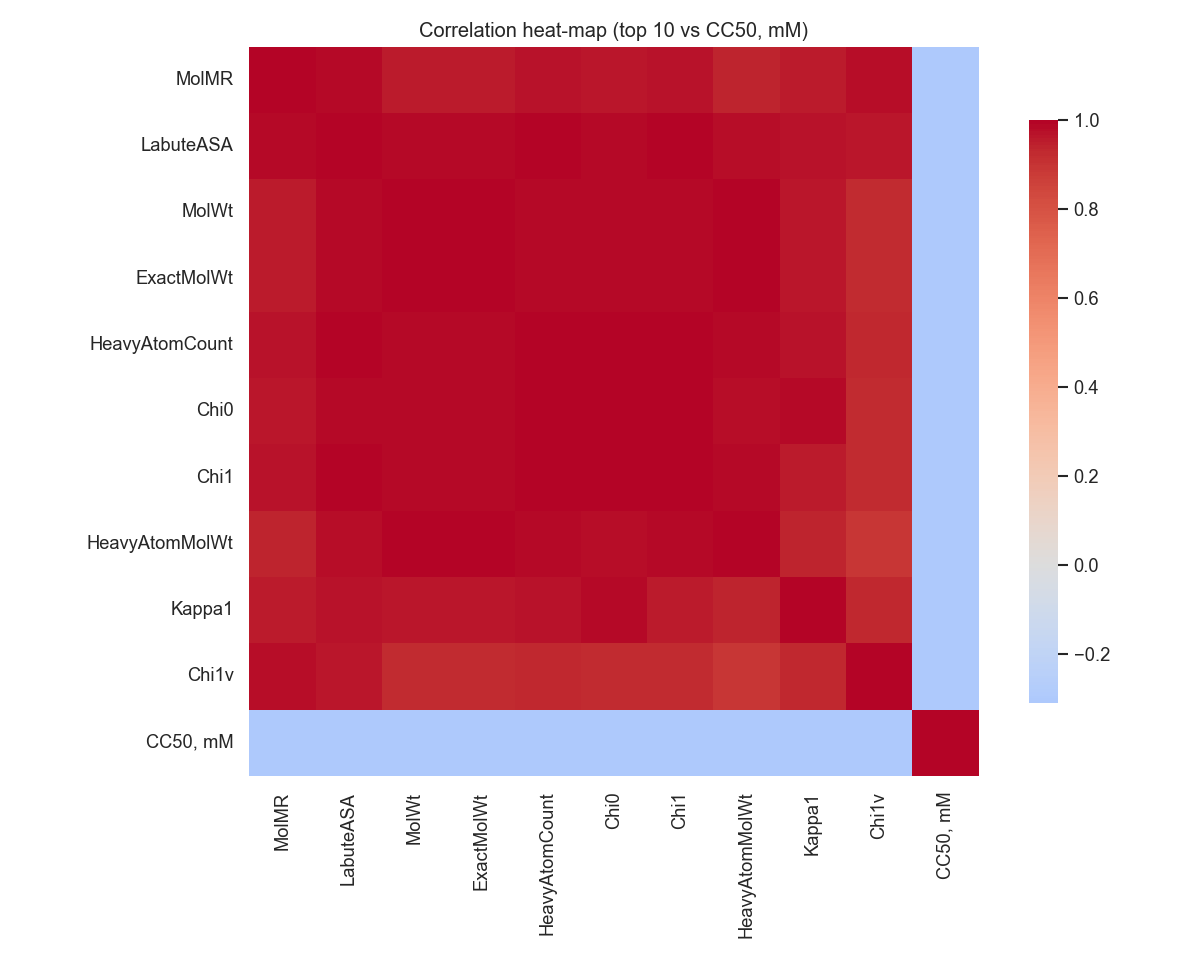

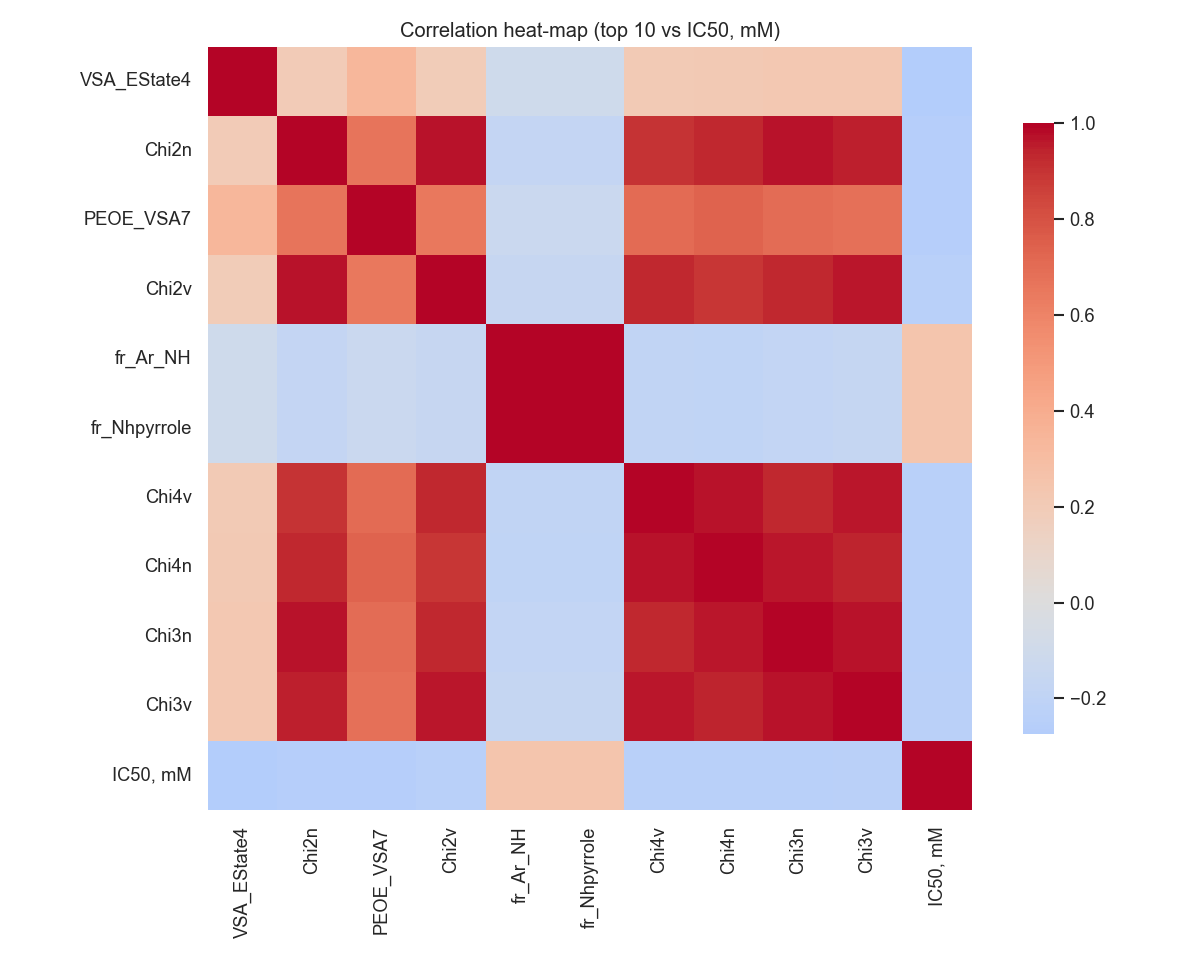

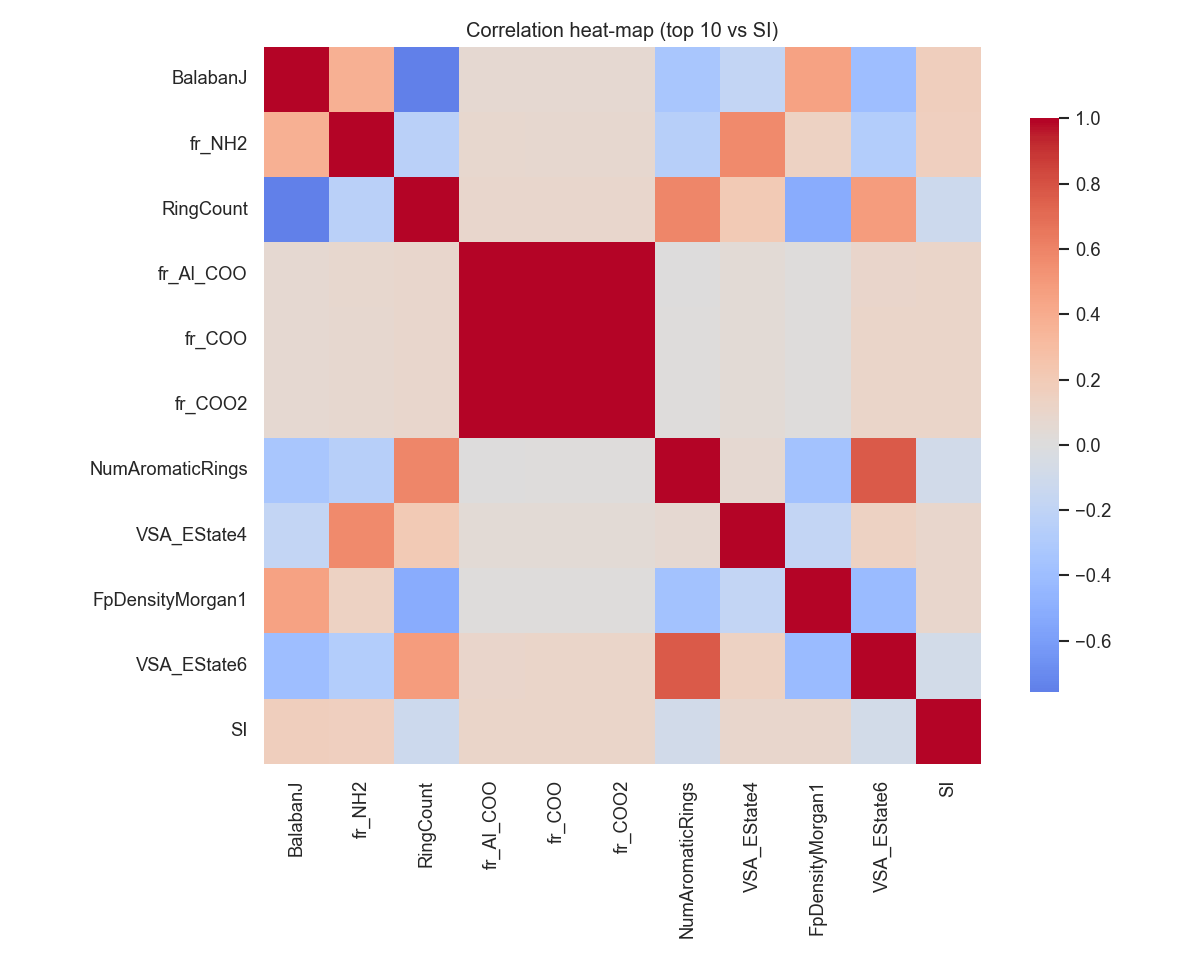

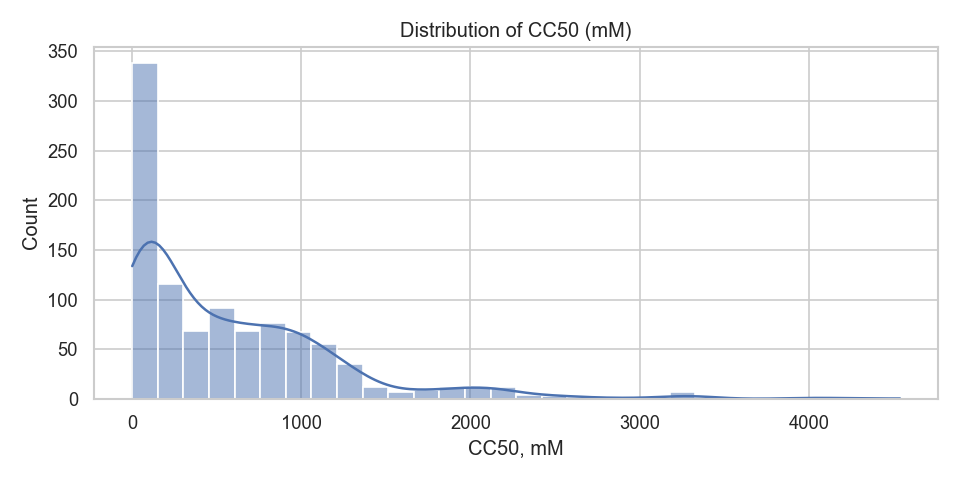

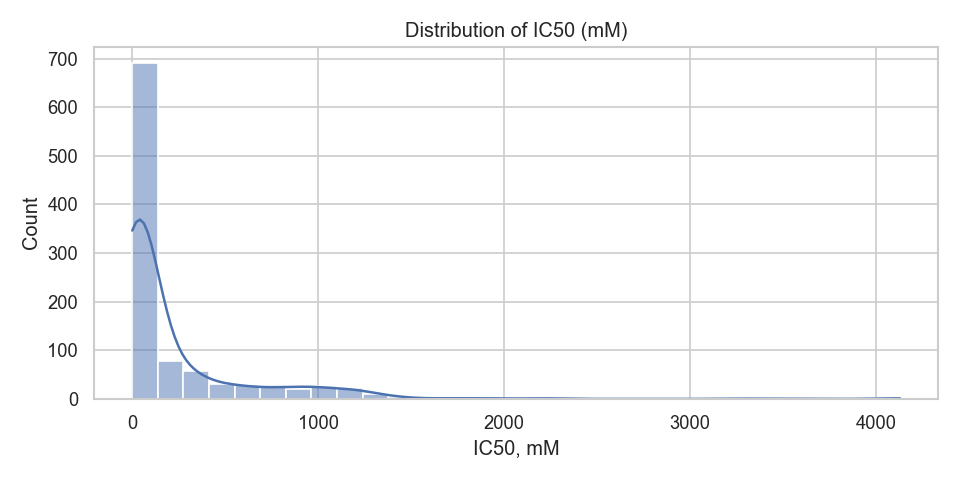

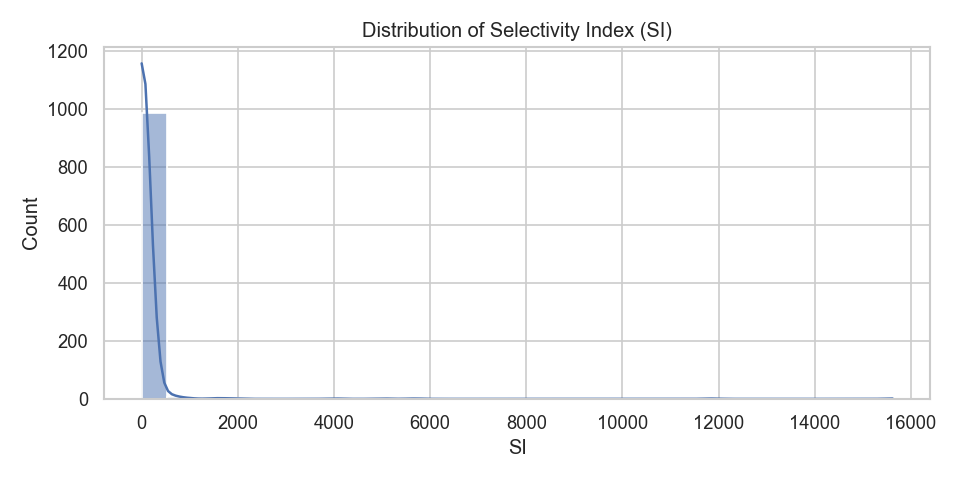

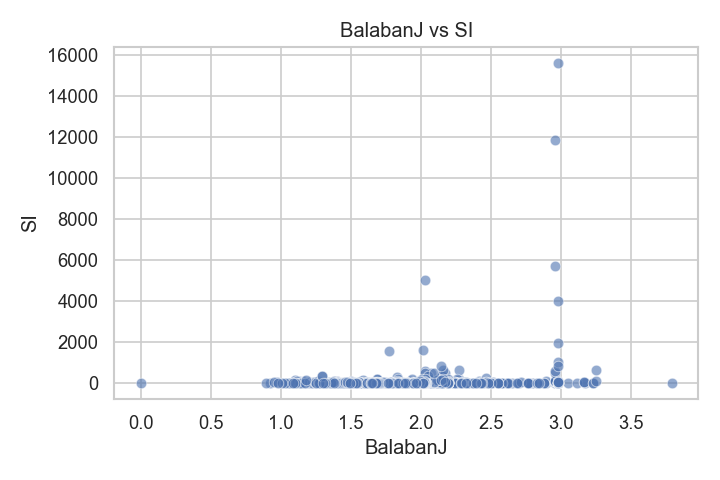

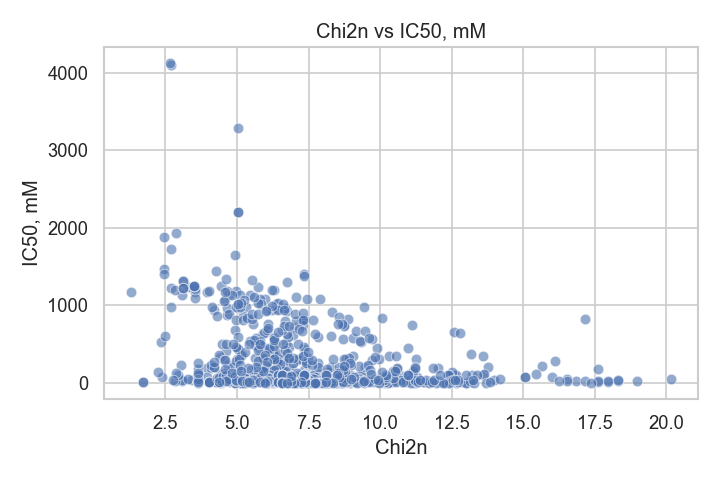

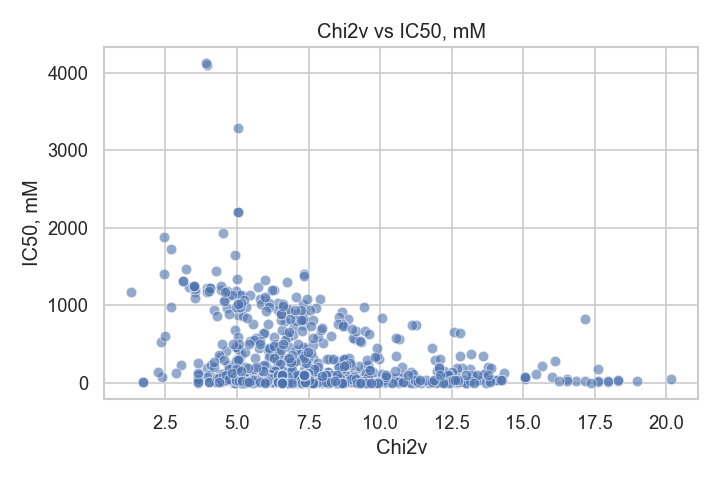

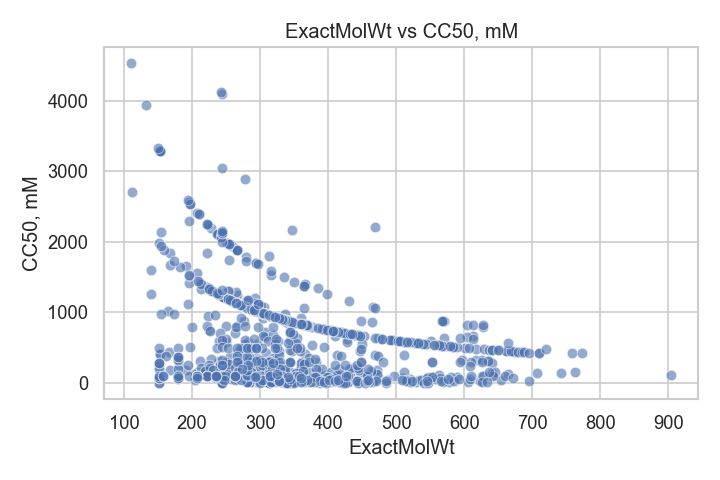

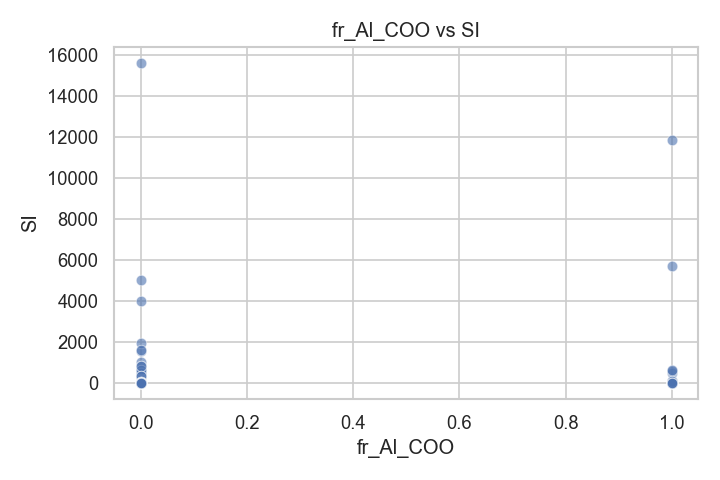

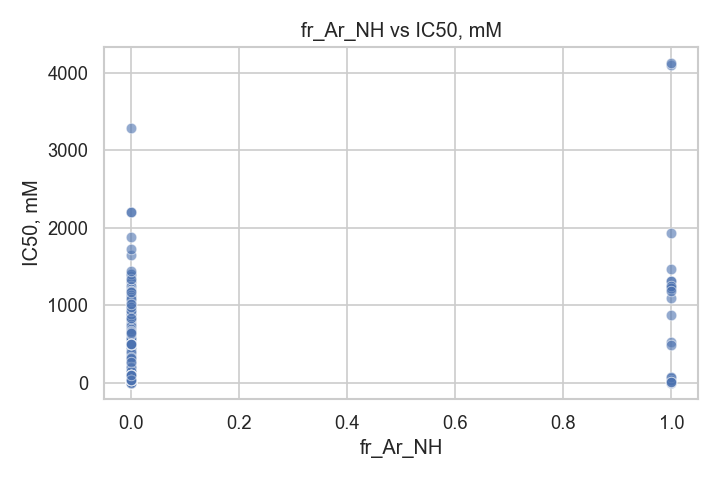

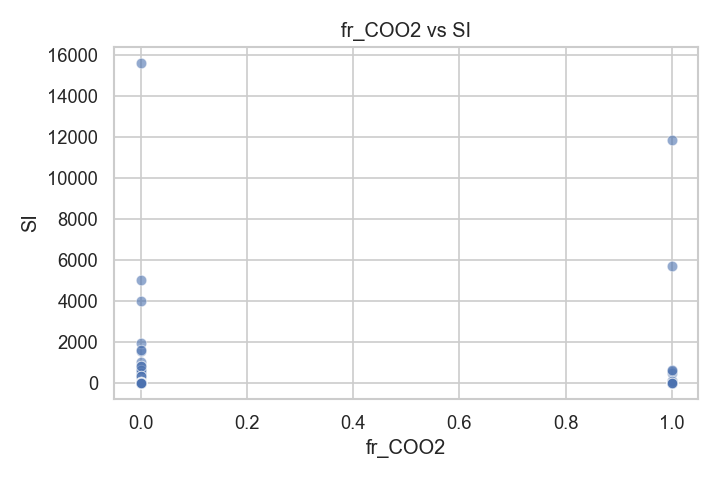

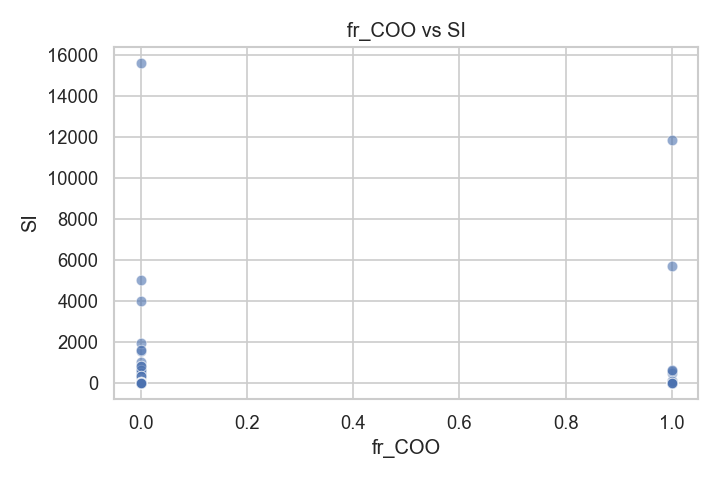

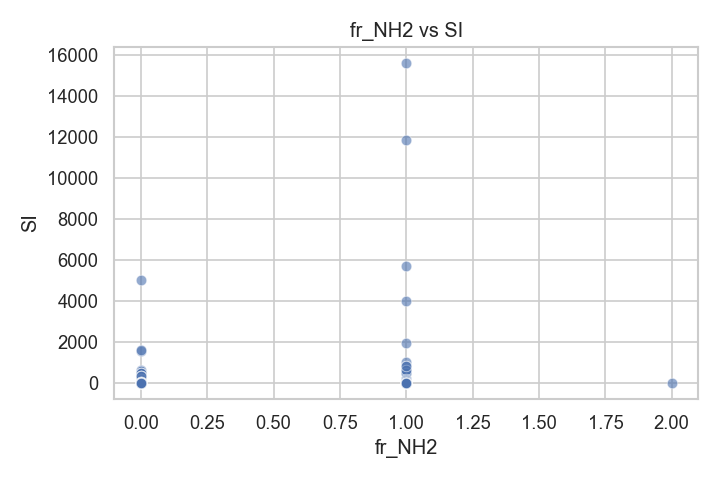

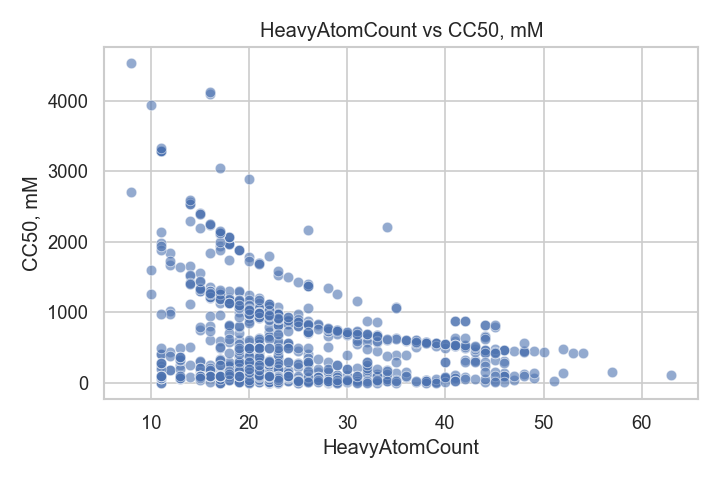

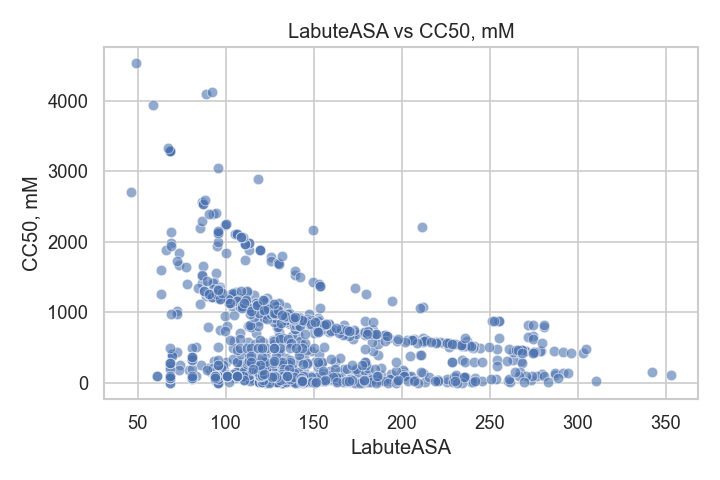

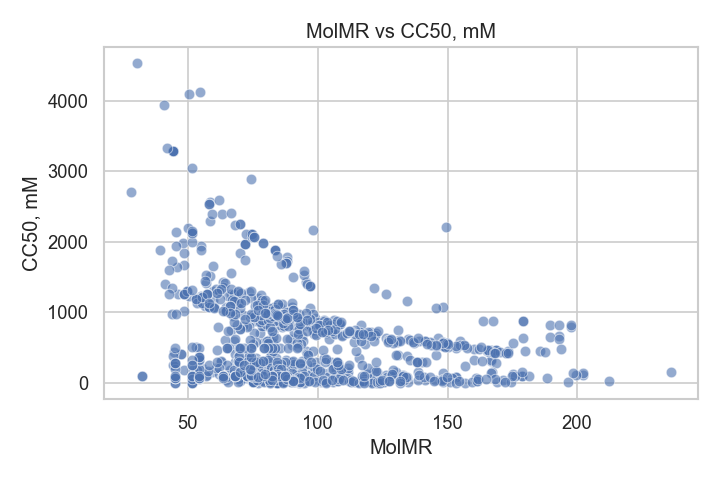

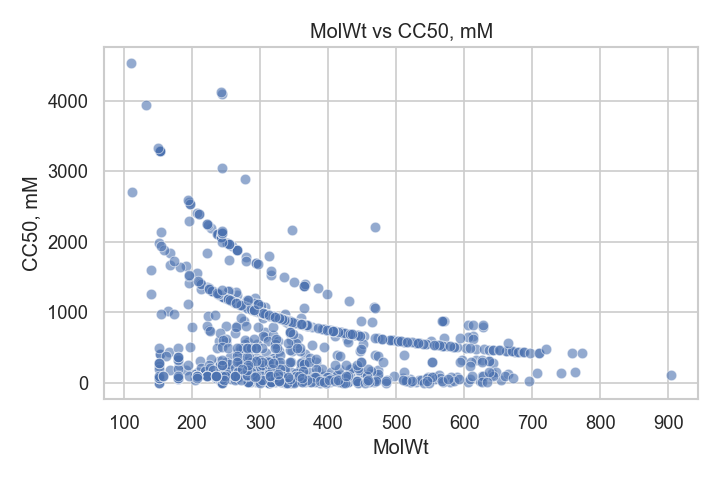

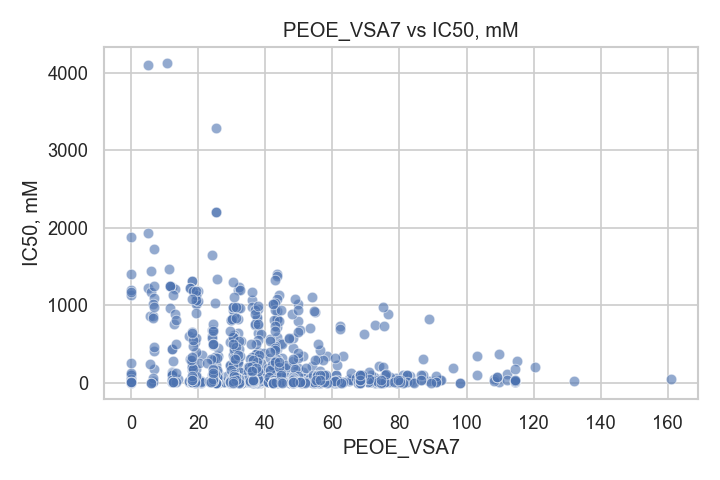

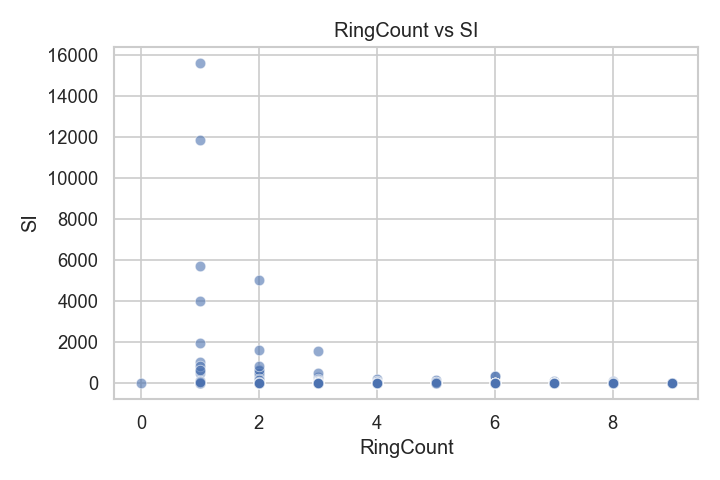

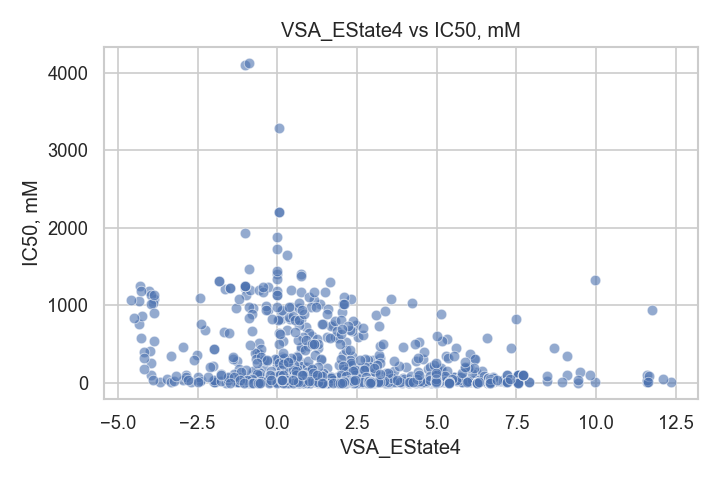

In [12]:
from IPython.display import Image, display
data_file = Path("data.xlsx")
df = load_data(data_file)

plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)


print("===== Basic Summary =====")
basic_summary(df)

print("\n===== Plotting target distributions =====")
plot_target_distributions(df, plots_dir)

for target in TARGET_COLS:
    print(f"\n===== Correlation analysis for {target} =====")
    plot_top_correlations(df, target, plots_dir, k=5)
    plot_correlation_heatmap(df, plots_dir, target, k=10)

print(f"\nAll plots saved to {plots_dir.resolve()}")

for img_path in sorted(plots_dir.glob("*.png")):
    display(Image(filename=str(img_path)))